In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
def load_data(path):
    return pd.read_csv(path, parse_dates=["Datetime"], index_col="Datetime")


In [9]:
path = "../data/PJME_hourly.csv"
df = load_data(path)

'Datetime'

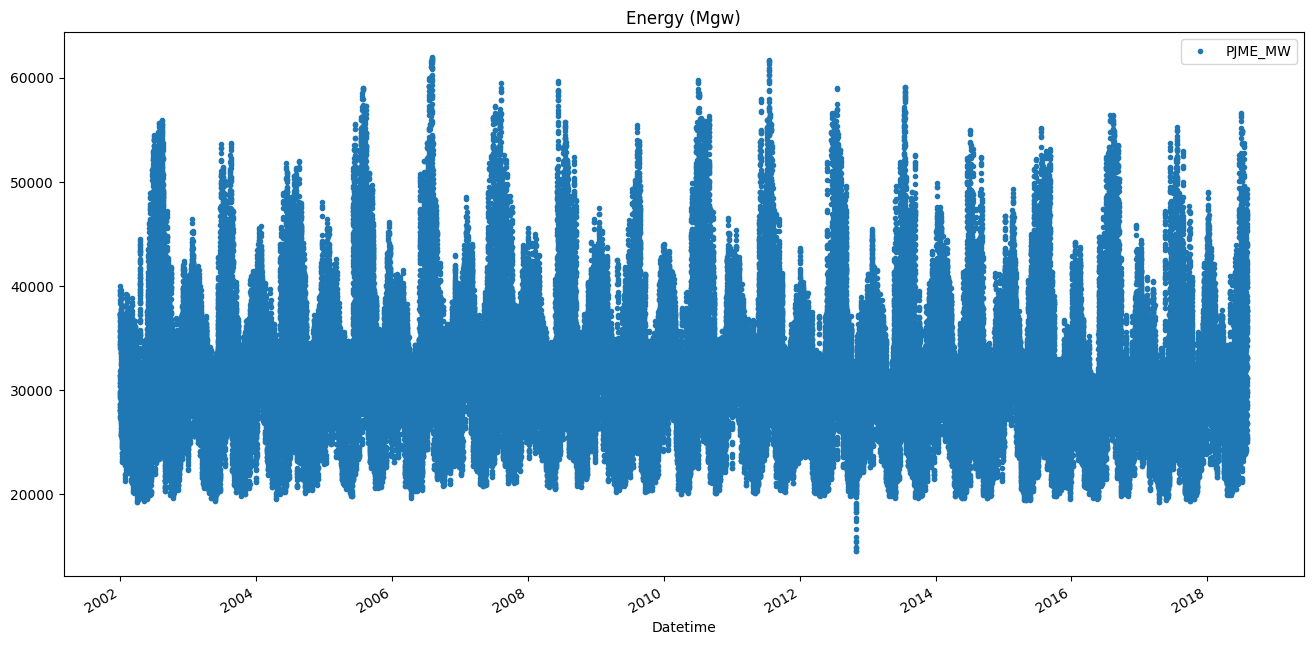

In [10]:
df.plot(figsize=(16,8), style='.')
plt.title('Energy (Mgw)')
plt.show()

In [11]:
# Basic features
df["year"] = df.index.year
df["month"] = df.index.month
df["day"] = df.index.day
df["hour"] = df.index.hour  # If hourly data
df["day_of_week"] = df.index.dayofweek  # 0=Monday, 6=Sunday
df["day_of_year"] = df.index.dayofyear
df["week_of_year"] = df.index.isocalendar().week  # Week number (1-52/53)

# Day names (e.g., "Monday", "Tuesday")
df["day_name"] = df.index.day_name()

# Month names (e.g., "January", "February")
df["month_name"] = df.index.month_name()

# Weekend flag (1 if weekend, 0 otherwise)
df["is_weekend"] = (df.index.dayofweek >= 5).astype(int)

# Cyclical encoding for "hour"
df["hour_sin"] = np.sin(2 * np.pi * df.index.hour / 24)
df["hour_cos"] = np.cos(2 * np.pi * df.index.hour / 24)

# Cyclical encoding for "month"
df["month_sin"] = np.sin(2 * np.pi * df.index.month / 12)
df["month_cos"] = np.cos(2 * np.pi * df.index.month / 12)

# Rolling 7-day average (if daily data)
df["7_day_avg"] = df["PJME_MW"].rolling(window=7).mean()

# Lag features (e.g., value from 24 hours ago)
df["lag_24h"] = df["PJME_MW"].shift(24)  # For hourly data

In [15]:
df["day_name"]

Datetime
2002-12-31 01:00:00    Tuesday
2002-12-31 02:00:00    Tuesday
2002-12-31 03:00:00    Tuesday
2002-12-31 04:00:00    Tuesday
2002-12-31 05:00:00    Tuesday
                        ...   
2018-01-01 20:00:00     Monday
2018-01-01 21:00:00     Monday
2018-01-01 22:00:00     Monday
2018-01-01 23:00:00     Monday
2018-01-02 00:00:00    Tuesday
Name: day_name, Length: 145366, dtype: object

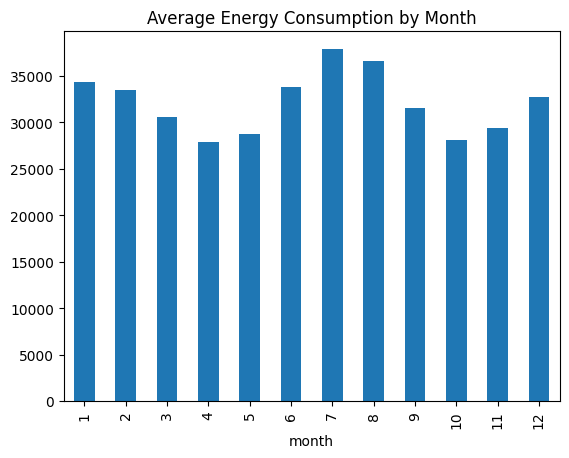

In [16]:
df.groupby("month")["PJME_MW"].mean().plot(kind="bar")
plt.title("Average Energy Consumption by Month")
plt.show()

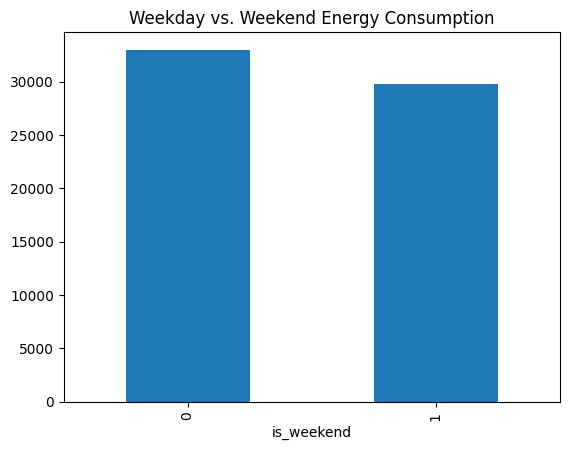

In [16]:
df.groupby("is_weekend")["PJME_MW"].mean().plot(kind="bar")
plt.title("Weekday vs. Weekend Energy Consumption")
plt.show()


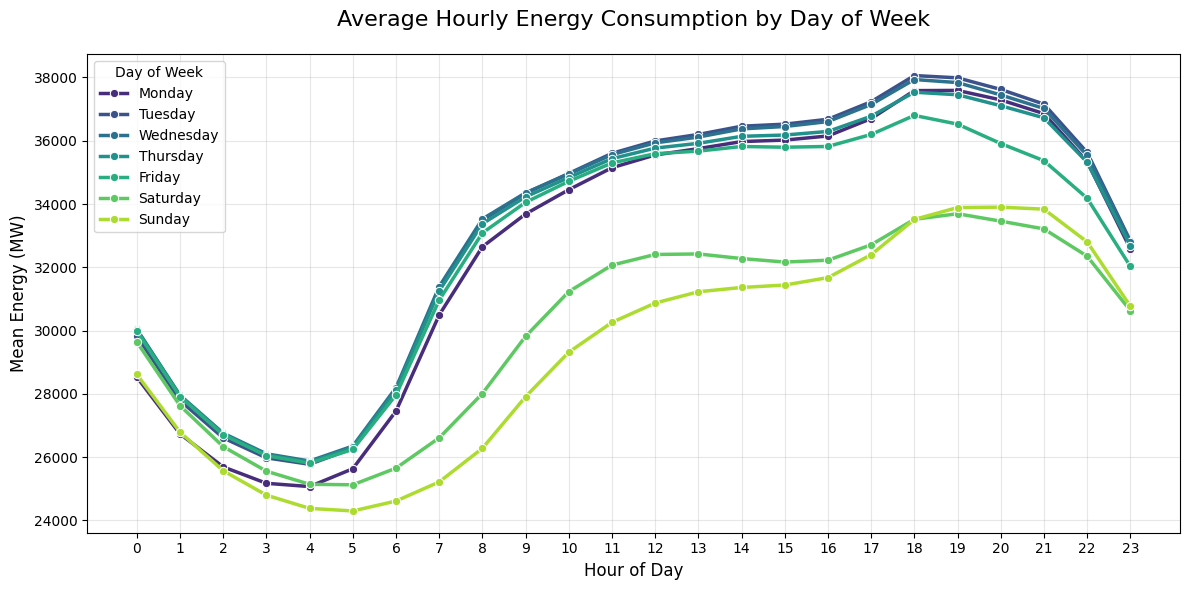

In [17]:
daily_hourly_mean = df.groupby(["day_name", "hour"])["PJME_MW"].mean().reset_index()

plt.figure(figsize=(12, 6))

# Define order of days (Monday to Sunday)
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

sns.lineplot(
    data=daily_hourly_mean,
    x="hour",
    y="PJME_MW",
    hue="day_name",
    hue_order=day_order,
    palette="viridis",
    linewidth=2.5,
    marker="o"
)

# Customize plot
plt.title("Average Hourly Energy Consumption by Day of Week", fontsize=16, pad=20)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Mean Energy (MW)", fontsize=12)
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.legend(title="Day of Week", loc="upper left")

plt.tight_layout()
plt.show()

# Adding holidays

In [25]:
import holidays

us_holidays = holidays.US(years=df.index.year.unique())

df["holiday_dates"] = df[df["Datetime"].apply(lambda d: d in us_holidays)]


{datetime.date(2016, 1, 1): "New Year's Day", datetime.date(2016, 5, 30): 'Memorial Day', datetime.date(2016, 7, 4): 'Independence Day', datetime.date(2016, 9, 5): 'Labor Day', datetime.date(2016, 11, 11): 'Veterans Day', datetime.date(2016, 11, 24): 'Thanksgiving Day', datetime.date(2016, 12, 25): 'Christmas Day', datetime.date(2016, 12, 26): 'Christmas Day (observed)', datetime.date(2016, 1, 18): 'Martin Luther King Jr. Day', datetime.date(2016, 2, 15): "Washington's Birthday", datetime.date(2016, 10, 10): 'Columbus Day', datetime.date(2017, 1, 1): "New Year's Day", datetime.date(2017, 1, 2): "New Year's Day (observed)", datetime.date(2017, 5, 29): 'Memorial Day', datetime.date(2017, 7, 4): 'Independence Day', datetime.date(2017, 9, 4): 'Labor Day', datetime.date(2017, 11, 11): 'Veterans Day', datetime.date(2017, 11, 10): 'Veterans Day (observed)', datetime.date(2017, 11, 23): 'Thanksgiving Day', datetime.date(2017, 12, 25): 'Christmas Day', datetime.date(2017, 1, 16): 'Martin Luther

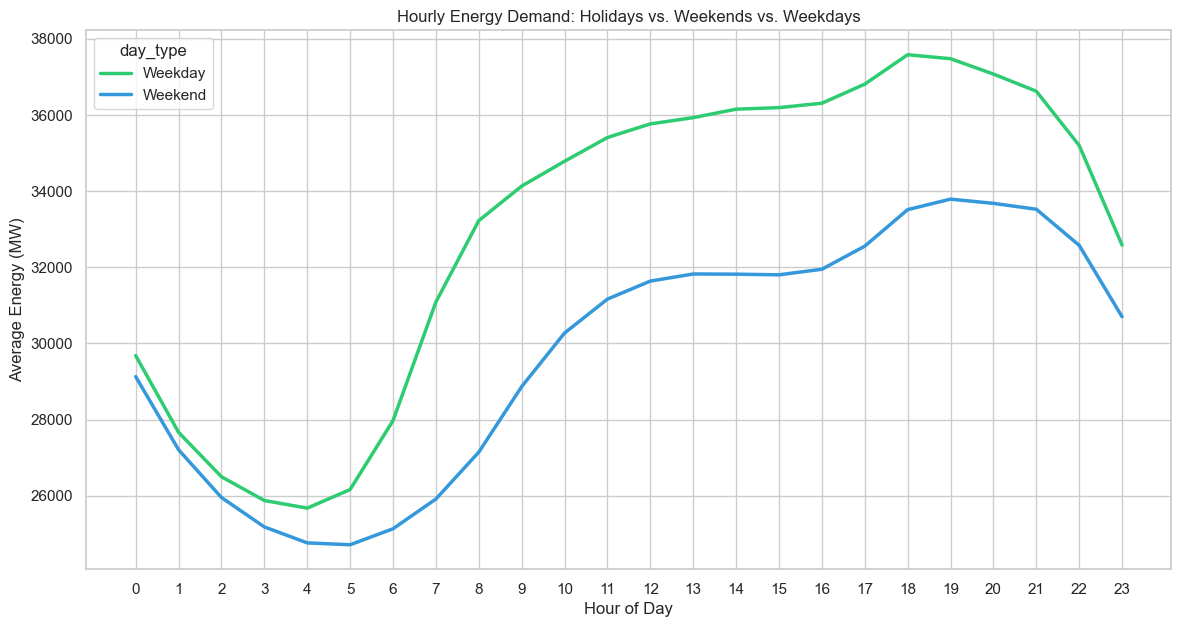

In [38]:
import holidays

# Generate list of US holidays (as datetime.date objects)
us_holidays = holidays.US(years=df.index.year.unique())
holiday_dates = list(us_holidays.keys())

if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index)

# Create a Series of dates from the index
index_dates = pd.Series(df.index.date)

df["is_holiday"] = index_dates.isin(holiday_dates).astype(int)


df["is_weekend"] = (df.index.dayofweek >= 5).astype(int)

# Classify days into "Holiday (Weekday)", "Holiday (Weekend)", "Weekend", "Weekday"
df["day_type"] = "Weekday"
df.loc[df["is_weekend"] == 1, "day_type"] = "Weekend"

holiday_mask = df["is_holiday"] == 1
df.loc[holiday_mask, "day_type"] = np.where(
    df.loc[holiday_mask, "is_weekend"] == 1, "Holiday (Weekend)", "Holiday (Weekday)"
)

# Calculate hourly averages
hourly_avg = df.groupby(["hour", "day_type"])["PJME_MW"].mean().reset_index()

# Plot
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=hourly_avg,
    x="hour",
    y="PJME_MW",
    hue="day_type",
    palette={"Holiday (Weekday)": "#e74c3c", "Holiday (Weekend)": "#9b59b6", "Weekend": "#3498db", "Weekday": "#2ecc71"},
    linewidth=2.5
)
plt.title("Hourly Energy Demand: Holidays vs. Weekends vs. Weekdays")
plt.xlabel("Hour of Day")
plt.ylabel("Average Energy (MW)")
plt.xticks(range(0, 24))
plt.show()

In [39]:
common_dates = set(df.index.date) & set(holiday_dates)
print("Number of holiday dates in the DataFrame:", len(common_dates))

Number of holiday dates in the DataFrame: 183


In [40]:
print(df['day_type'].value_counts())

day_type
Weekday    103871
Weekend     41495
Name: count, dtype: int64


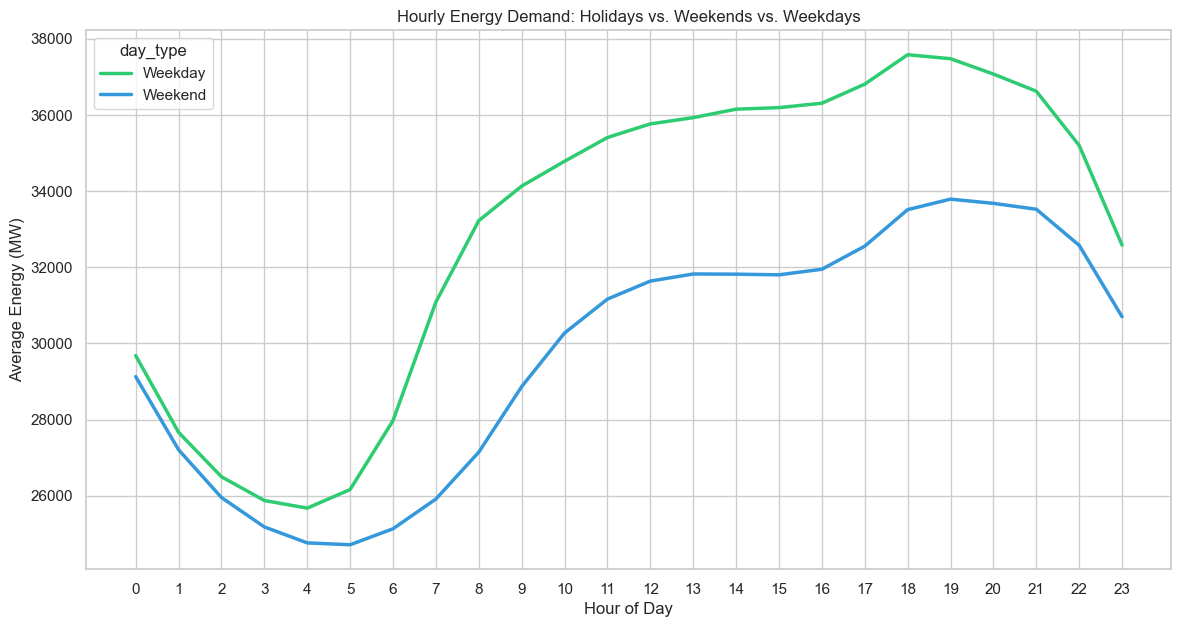

In [41]:
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index)

# Generate list of US holidays (as datetime.date objects)
us_holidays = holidays.US(years=df.index.year.unique())
holiday_dates = list(us_holidays.keys())

# Create a Series of dates from the index
index_dates = pd.Series(df.index.date)

# Flag holidays in the DataFrame
df["is_holiday"] = index_dates.isin(holiday_dates).astype(int)

# Flag weekends (Saturday & Sunday)
df["is_weekend"] = (df.index.dayofweek >= 5).astype(int)

# Classify days into "Holiday (Weekday)", "Holiday (Weekend)", "Weekend", "Weekday"
df["day_type"] = "Weekday"  # default assignment
df.loc[df["is_weekend"] == 1, "day_type"] = "Weekend"  # mark weekends first

# Now override with holiday classifications using explicit boolean conditions
df.loc[(df["is_holiday"] == 1) & (df["is_weekend"] == 1), "day_type"] = "Holiday (Weekend)"
df.loc[(df["is_holiday"] == 1) & (df["is_weekend"] == 0), "day_type"] = "Holiday (Weekday)"

# If your DataFrame doesn't already have an 'hour' column, extract the hour from the index
if "hour" not in df.columns:
    df["hour"] = df.index.hour

# Calculate hourly averages for each day_type
hourly_avg = df.groupby(["hour", "day_type"])["PJME_MW"].mean().reset_index()

# Plot the results
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=hourly_avg,
    x="hour",
    y="PJME_MW",
    hue="day_type",
    palette={
        "Holiday (Weekday)": "#e74c3c", 
        "Holiday (Weekend)": "#9b59b6", 
        "Weekend": "#3498db", 
        "Weekday": "#2ecc71"
    },
    linewidth=2.5
)
plt.title("Hourly Energy Demand: Holidays vs. Weekends vs. Weekdays")
plt.xlabel("Hour of Day")
plt.ylabel("Average Energy (MW)")
plt.xticks(range(0, 24))
plt.show()

In [32]:
import holidays

# Create a US holidays dictionary for all years present in your data.
us_holidays = holidays.US(years=df.index.year.unique())

def classify_date(d):
    # Check if the date is a holiday.
    is_holiday = d in us_holidays
    # Weekends: Saturday (5) or Sunday (6)
    is_weekend = d.weekday() >= 5
    if is_holiday:
        return "Holiday (Weekend)" if is_weekend else "Holiday (Weekday)"
    else:
        return "Weekend" if is_weekend else "Weekday"

# Create a new column for day type using the index.
df["day_type"] = df.index.to_series().apply(classify_date)

# Create a new column for the hour extracted from the index.
df["hour"] = df.index.hour


In [ ]:

# Group by day_type and calculate the mean PJME_MW.
grouped = df.groupby("day_type")["PJME_MW"].mean()

# Plot the mean PJME_MW by day_type.
grouped.plot(kind="bar")
plt.ylabel("Mean PJME_MW")
plt.title("Mean PJME_MW by Day Type")
plt.show()


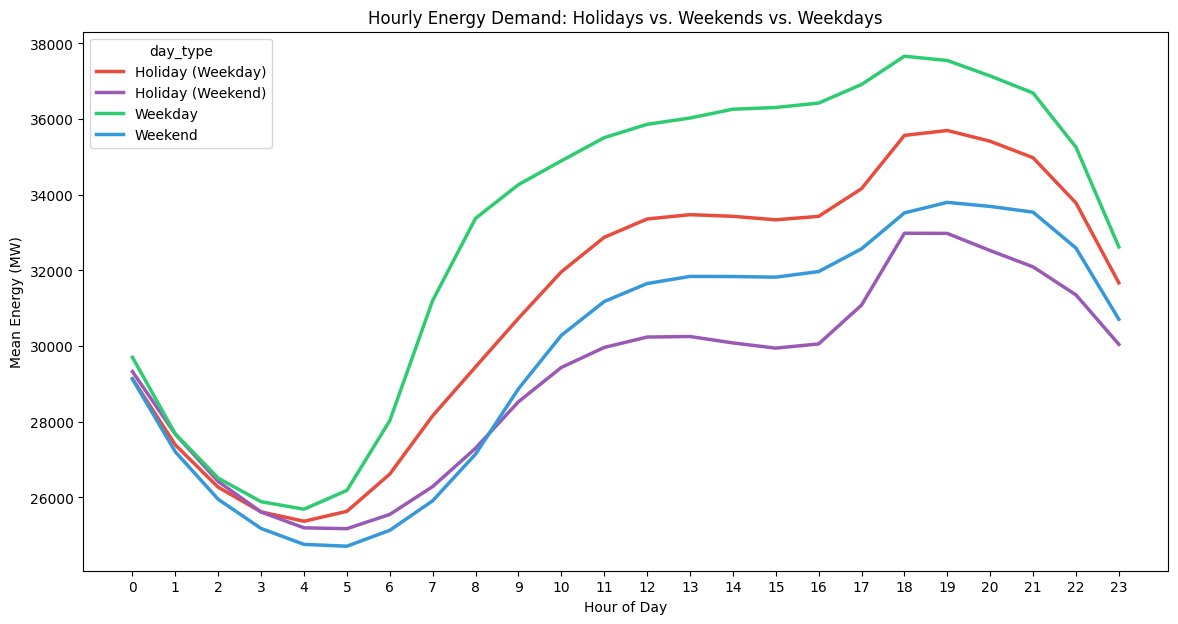

In [38]:
# Calculate hourly averages for each day_type.
hourly_avg = df.groupby(["hour", "day_type"])["PJME_MW"].mean().reset_index()

# Plot the hourly averages with seaborn.
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=hourly_avg,
    x="hour",
    y="PJME_MW",
    hue="day_type",
    palette={
        "Holiday (Weekday)": "#e74c3c", 
        "Holiday (Weekend)": "#9b59b6", 
        "Weekend": "#3498db", 
        "Weekday": "#2ecc71"
    },
    linewidth=2.5
)
plt.title("Hourly Energy Demand: Holidays vs. Weekends vs. Weekdays")
plt.xlabel("Hour of Day")
plt.ylabel("Mean Energy (MW)")
plt.xticks(range(24))
plt.show()